
The SEM dataset is composed of a training and a validation images acquired on a scanning 
electron microscopy (SEM). They were originally used in Buchholtz et al (2019) to showcase
CARE denoising. Here, we demonstrate the performances of Noise2Void!

In [4]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import tifffile
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics_portfolio import PortfolioManager

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [5]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_SEM.download(root_path)

## Visualize data

Text(0.5, 1.0, 'Validation Image')

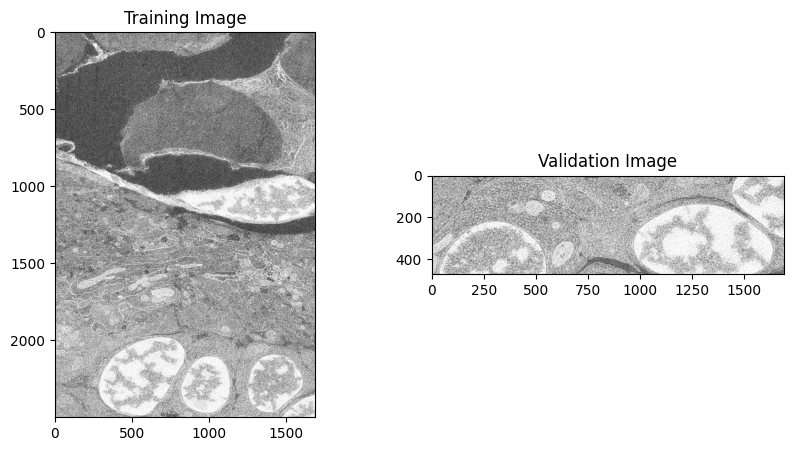

In [8]:
# load training and validation image and show them side by side
train_image = tifffile.imread(files[0])
val_image = tifffile.imread(files[1])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[0].set_title("Training Image")
ax[1].imshow(val_image, cmap="gray")
ax[1].set_title("Validation Image")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

In [9]:
config = create_n2v_configuration(
    experiment_name="sem_n2v",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=32,
    num_epochs=30,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 32,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'mean': 0.485,
      

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [8]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
    val_source=val_image,
)

No working directory provided. Using current working directory: /Users/joran.deschamps/git/careamics/careamics-examples/applications/n2v/2D.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [ ]:
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

### Visualize the prediction

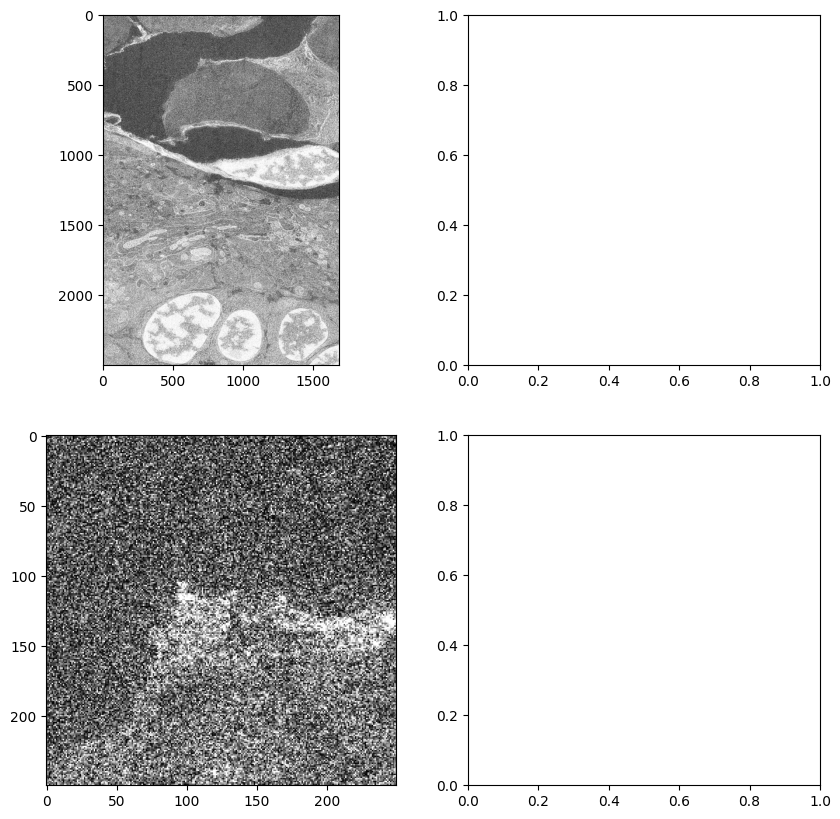

In [15]:
# Show the full image and crops
x_start, x_end = 600, 850
y_start, y_end = 200, 450

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 1].imshow(prediction.squeeze(), cmap="gray")
ax[1, 0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 1].imshow(prediction.squeeze()[y_start:y_end, x_start:x_end], cmap="gray")

In [ ]:
# Show a crop
y_start = 200
y_end = 450
x_start = 600
x_end = 850

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1].imshow(prediction.squeeze()[y_start:y_end, x_start:x_end], cmap="gray")

## Export the model

The model is automatically saved during training (the so-called `checkpoints`) and can 
be loaded back easily, but you can also export the model to the [BioImage Model Zoo](bioimage.io)
format.

In [ ]:
careamist.export_to_bmz(
    path="sem_n2v_model.zip",
    name="SEM_N2V",
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
)